# Building multiple linear regression model

### 1. Import open-source python libraries etc.

In [1]:
import pandas as pd
import numpy as np
import os
import time
from azure.storage.blob import BlockBlobService, ContentSettings # if there is an error, enter the following command in the terminal:
                                           # pip freeze
                                           # pip install azure-storage==0.36.0
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### 2. Import data from personal blob storage account in Azure

In [2]:
# CONTAINERNAME = 'xxxx'
# STORAGEACCOUNTNAME = 'xxxx'
# STORAGEACCOUNTKEY = 'xxxx'
# BLOBNAME = 'xxxx'
# localfilename = 'xxxx'
# LOCALDIRECTORY = os.getcwd()
# LOCALFILE =  os.path.join(LOCALDIRECTORY, localfilename)

CONTAINERNAME = 'air-pollution'
STORAGEACCOUNTNAME = 'alvinmlcrsf6983556517'
STORAGEACCOUNTKEY = 'H2vFRPo/aL9Tzk716PisEsfvOLA0l2dqYeI2SgaZ7XVqbc1m9qusnrgj7zLdPJyHneiMXkkfBz5MB0ZACbs2yQ=='
BLOBNAME = 'PRSA_data_2010.1.1-2014.12.31.csv'
localfilename = 'PRSA_data_2010.1.1-2014.12.31.csv'
LOCALDIRECTORY = os.getcwd()
LOCALFILE =  os.path.join(LOCALDIRECTORY, localfilename)

#download from blob
t1 = round(time.time(),3)
blob_service = BlockBlobService(account_name=STORAGEACCOUNTNAME,account_key=STORAGEACCOUNTKEY)
blob_service.get_blob_to_path(CONTAINERNAME,BLOBNAME,LOCALFILE)
t2 = round(time.time(),3)
print(("It takes %s seconds to download "+ BLOBNAME) % round((t2 - t1),3))

#unzipping downloaded files if needed
#with zipfile.ZipFile(ZIPPEDLOCALFILE, "r") as z:
#    z.extractall(LOCALDIRECTORY)

raw_data = pd.read_csv(LOCALFILE, encoding='cp1252')
# raw_data

It takes 0.253 seconds to download PRSA_data_2010.1.1-2014.12.31.csv


### 3. Displaying data

In [3]:
raw_data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


### 4. Pre-processing of raw dataset 

In [4]:
# to remove rows with pm2.5 = NaN
import math
for row_number in range(len(raw_data)):
    if math.isnan(float(raw_data['pm2.5'][row_number])):
        raw_data.drop([row_number], inplace=True)
raw_data.reset_index(inplace=True)
raw_data.head()

,index,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [5]:
# compute the total number of seconds as starting from time = 0s at index row = 0
list_1 = [1,3,5,7,8,10,12]
list_2 = [4,6,9,12]
list_3 = [2]

time = list()
total_time = 0
for row_number in range(len(raw_data)):
    if raw_data['month'][row_number] in list_1:
        dummy_time = raw_data['month'][row_number] * 31 * 86400 + \
        raw_data['day'][row_number] * 86400 + raw_data['hour'][row_number] * 3600
    elif raw_data['month'][row_number] in list_2:
        dummy_time = raw_data['month'][row_number] * 30 * 86400 + \
        raw_data['day'][row_number] * 86400 + raw_data['hour'][row_number] * 3600
    else:
        dummy_time = raw_data['month'][row_number] * 28 * 86400 + \
        raw_data['day'][row_number] * 86400 + raw_data['hour'][row_number] * 3600
    total_time += dummy_time
    time.append(total_time)
raw_data['Total time(s)'] = time
raw_data.head()

,index,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,Total time(s)
0,24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2851200
1,25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,5706000
2,26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,8564400
3,27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,11426400
4,28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,14292000


In [6]:
# dropping unwanted columns
raw_data.drop(columns=['year','index','No','month','day','hour','cbwd','Is','Ir'], inplace=True)
raw_data.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Total time(s)
0,129.0,-16,-4.0,1020.0,1.79,2851200
1,148.0,-15,-4.0,1020.0,2.68,5706000
2,159.0,-11,-5.0,1021.0,3.57,8564400
3,181.0,-7,-5.0,1022.0,5.36,11426400
4,138.0,-7,-5.0,1022.0,6.25,14292000


In [7]:
# data extractions followed by features scaling
x_features = raw_data.iloc[:,1:]
y_target = raw_data.iloc[:,0]
# print(x_features)
# print('')
# print(y_target)
x_train,x_test,y_train,y_test = train_test_split(x_features,y_target,test_size = 0.2)
# print(x_train)
# print('')
# print(y_train)
# print('')
# print(x_test)
# print('')
# print(y_test)
# print('')
x_train_array = (np.array(x_train))
X_train = x_train_array.reshape(len(x_train),-1)
y_train_array = (np.array(y_train))
Y_train = y_train_array.reshape(len(y_train),-1)
x_test_array = (np.array(x_test))
X_test = x_test_array.reshape(len(x_test),-1)
y_test_array = (np.array(y_test))
Y_test = y_test_array.reshape(len(y_test),-1)
# print(X_train)
# print('')
# print(Y_train)
# print('')
# print(X_test)
# print('')
# print(Y_test)
# print('')

scalar = StandardScaler()
X_train_features_scaled = scalar.fit_transform(X_train)
X_test_features_scaled = scalar.fit_transform(X_test)
# print(X_train_features_scaled)
# print('')
# print(Y_train)

### 5. Model training and validation

[[ 58.85775032 -71.151928   -15.03748878 -13.5126734    0.74648491]] [98.25364466]
The r^2 value is -2.452.

The average error for the validation step is 121.03%.



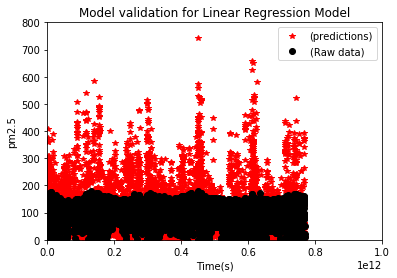

In [9]:
# Using Batch Gradient Descent to train model
name = 'june6results_multiple_regression'
os.mkdir(name)
linear_model_GD = LinearRegression() 
model_train_GD = linear_model_GD.fit(X_train_features_scaled,Y_train)
m = model_train_GD.coef_
c = model_train_GD.intercept_
print(m,c)

# Validating trained model
y_pred = model_train_GD.predict(X_test_features_scaled)

# compute accuracy of model
r2_value = r2_score(y_pred,Y_test)
# mse = mean_squared_error(y_pred,y_test)
# mae = mean_absolute_error(y_pred,y_test)
# rmse = sqrt(mse)
print('The r^2 value is ' + str(round(r2_value,3)) + '.')
print('')
total_error = 0
avg_error = 0
for i in range(len(y_pred)):
    total_error += (abs(y_pred[i]-Y_test[i])/min(y_pred[i],Y_test[i]))
avg_error = (total_error/len(y_pred)) * 100
print('The average error for the validation step is ' + str(round(float(avg_error),2)) + '%' + '.')
print('')

# exporting of data into DataFrame format
title_1 = 'Time(s)' 
title_2 = 'Actual pm2.5 data'
title_3 = 'Predicted pm2.5 data' 
data_table_linear_reg = pd.DataFrame(columns=[title_1, title_2, title_3])
data_table_linear_reg[title_1] = x_test.iloc[:,-1]
data_table_linear_reg[title_2] = Y_test
data_table_linear_reg[title_3] = [y_pred[i][0] for i in range(len(y_pred))]
data_table_linear_reg.to_csv('june6results_multiple_regression/linear_reg.csv')

# plotting of graph
graph1 = plt.plot(x_test.iloc[:,-1],y_test,'*', label ='(predictions)',color = 'r')
graph2 = plt.plot(x_test.iloc[:,-1],y_pred,'o', label = '(Raw data)',color = 'k')
plt.xlabel('Time(s)')
plt.ylabel('pm2.5')
plt.title('Model validation for Linear Regression Model')
# plt.grid(color='r', linestyle='', linewidth=2)
legend = plt.legend()
leg_lines = legend.get_lines()
leg_texts = legend.get_texts()
plt.setp(leg_lines, linewidth=1.5)
plt.axis([0, 9*10e10, 0, 800])
plt.show()

### 6. Exporting predictions dataset to blob storage account in Azure

In [10]:
# create additional storage container to store results in Azure 
from azure.storage.blob import BlockBlobService, ContentSettings, PublicAccess

block_blob_service = BlockBlobService(account_name = STORAGEACCOUNTNAME, account_key=STORAGEACCOUNTKEY)
results_container = 'june6-results'
block_blob_service.create_container(results_container)
block_blob_service.set_container_acl(results_container, public_access=PublicAccess.Container)

In [11]:
#Upload the CSV file to Azure cloud
# block_blob_service.create_blob_from_path(results_container,
#                                         'june6results/linear_reg.csv',
#                                         'june6results/linear_reg.csv',
#                                         content_settings=ContentSettings(content_type='application/CSV')
#                                         )
path = name
for filename in os.listdir(path):
    block_blob_service.create_blob_from_path(results_container,
                                             str(name) + "/" + str(filename),
                                             str(name) + "/" + str(filename),
                                             content_settings=ContentSettings(content_type='application/CSV')
                                             )